In [11]:
import sys
import os
# Get the path of the directory containing the script
script_dir = os.path.join(os.getcwd(), 'CofI_Functions')

# Add the directory to the system path
sys.path.append(script_dir)


In [12]:
import CofI_KOSMOS as pipe

In [13]:
# Making all necessary imports.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ccdproc import CCDData
from ccdproc import Combiner, trim_image
from ccdproc import cosmicray_lacosmic
from specutils import Spectrum1D
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy.io import fits
import sys
from pathlib import Path
script_py = os.path.join(os.getcwd(), 'pykosmos')
sys.path.append(script_py)
#sys.path.append("path/to/CofI_Functions")
#sys.path.insert(1,'path/to/CofI_Functions')
#sys.path.append("pykosmos/pykosmos")
#sys.path.append("cofi-kosmos-pipe-funcs/CofI_KOSMO")
#import CofI_KOSMOS as pipe
from pykosmos import pykosmos

In [5]:
# Mounting Google Drive.
#from google.colab import drive
#drive.mount('/content/drive')

# The blocks above are for necessary imports and for mounting Google Drive.

Setting DISPLAY to boolean True for future use.

In [14]:
# Setting the variable "DISPLAY" to boolean True. "DISPLAY" will be used throughout the pipeline.
DISPLAY = True

# Bias

Creating an array of all bias files to work with.

In [7]:
# The code below creates a text file that contains all the bias files in our particular data.
# User may use any other method to create this object.
directory_orig = "UT230908/UT230908/UT230908/"
with open('biaslist.txt', 'w') as f:
    for num in range(72,77):
      f.write("Bias.00{}.fits".format(num) + "\n")
    #f.write("zero.0010.fits" + "\n")
# Read the text file into a table, the list of column names to use has only one name, "impath".
biasfiles_i = pd.read_table("biaslist.txt", names = ['impath'])
# Returning an array of the bias files.
biasfiles = directory_orig + biasfiles_i['impath'].values
biasfiles

array(['UT230908/UT230908/UT230908/Bias.0072.fits',
       'UT230908/UT230908/UT230908/Bias.0073.fits',
       'UT230908/UT230908/UT230908/Bias.0074.fits',
       'UT230908/UT230908/UT230908/Bias.0075.fits',
       'UT230908/UT230908/UT230908/Bias.0076.fits'], dtype=object)

Combining bias files and displaying the combined bias frame.

In [8]:
# Creating a path object to use throughout the pipeline.
directory_new = "reduced file/ignas/"
path = Path(directory_new)

#Personal path
directory_new_saves = "/home/igbongon/Desktop/sciimg"
path_personal = Path(directory_new_saves)



 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


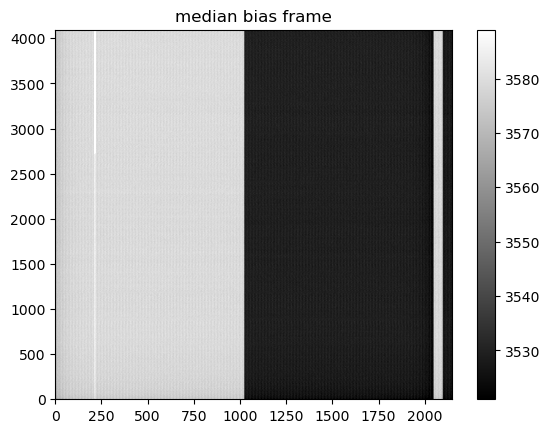

In [9]:
##### Using Jim Davenport's "kosmos.biascombine" function to combine bias frames.
bias = pykosmos.biascombine(biasfiles)
# Creating a path object to use throughout the pipeline.
directory_new = "reduced file/ignas/"
path = Path(directory_new)
# Choosing file name.
filename = 'bias_combined.fits'
# The code below saves the combined bias frame as a "fits" file.
# Please make sure to run the following block of code (until the next comment) only once,
# otherwise, you will be attempting to save a file that already exists.
# Thus, please comment this block of code out once you run it.
hdu = fits.PrimaryHDU(bias)
hdu.writeto(path / filename,overwrite = True)
# The code below plots the combined bias frame.
plt.imshow(bias, origin ='lower',aspect ='auto',cmap = plt.cm.gray)
plt.title('median bias frame')
plt.clim(np.percentile(bias, (5, 98)))
cb = plt.colorbar()
plt.show()

##############SAVING THE SCIENCE IMAGE###############
# Choosing file name.
filename = 'biascombine.fits'
hdu = fits.PrimaryHDU(bias)
hdu.writeto(path_personal / filename,overwrite = True)
#####################################################

# Darks

In [10]:
#from pykosmos.pykosmos import imtools

In [11]:
#from cofi_kosmos_pipe_funcs.CofI_KOSMOS import darkcombine_and_apo_proc as pipe

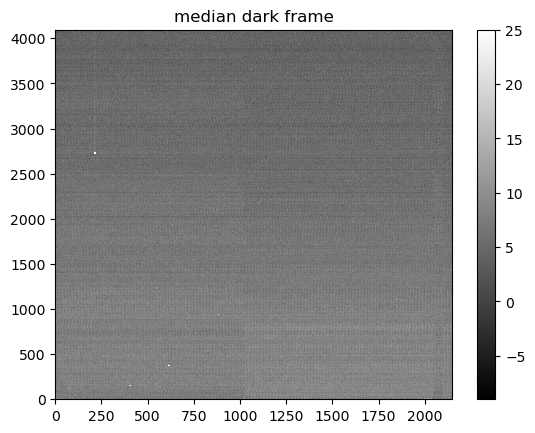

In [12]:
# The code below creates a text file that contains all the dark files in our particular data.
# User may use any other method to create this object.
with open('darklist_def.txt', 'w') as f9:
    for num in range(69,72):
      f9.write("dark90.00{}.fits".format(num) + "\n")
# Read the text file into a table, the list of column names to use has only one name, "impath".
# Returning an array of the dark files.
darkfiles_i_def = pd.read_table("darklist_def.txt", names = ['impath'])
darkfiles_def = directory_orig + darkfiles_i_def['impath'].values
# Using "darkcombine" function defined above, combining the dark files.
new_darks = pipe.darkcombine(darkfiles_def,bias =
"reduced file/ignas/bias_combined.fits",
directory = "reduced file/ignas/", trim = False)
# The code below plots the combined dark frame.
plt.imshow(new_darks, origin = 'lower',aspect = 'auto',cmap = plt.cm.gray)
plt.title('median dark frame')
plt.clim(np.percentile(new_darks, (5, 98)))
cb = plt.colorbar()
plt.show()

##############SAVING THE SCIENCE IMAGE###############
# Choosing file name.
filename = 'Median Dark.fits'
hdu = fits.PrimaryHDU(new_darks)
hdu.writeto(path_personal / filename,overwrite = True)
#####################################################



# Histogram of dark pixel values for combined dark frame with Poisson and Gaussian distributions fitted

The code in this section is for analyzing the need to use dark frames in data reduction. If the histogram follows Gaussian distribution, there is no need to subtract darks. If the histogram follows Poisson distribution, darks need to be subtracted.

Plotting the histogram with Gaussian and Poisson distributions.

0.0433665181212659


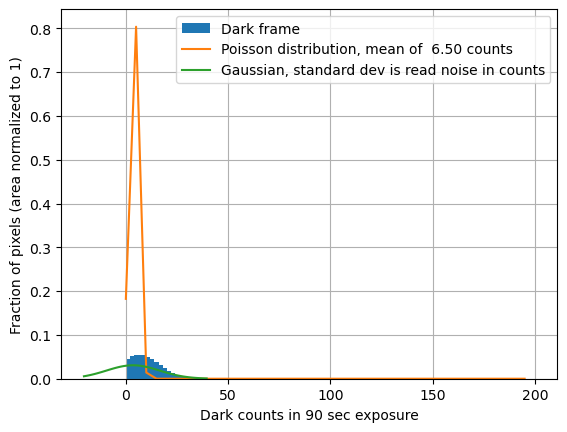

In [13]:
# Plotting histogram of dark pixel values in combined dark frame with Poisson and Gaussian distributions fitted.
# Making necessary imports.
# The following data is from APO KOSMOS Documentation (it is specific to the data used in this pipeline):
# https://www.apo.nmsu.edu/arc35m/Instruments/KOSMOS/userguide.html#4p3
# Section 3.2 Detector Characteristics
# The user can find gain and read noise values in the instrument documentation and exposure time
# in the image header or in the observing log.
gain = 0.6
exposure = 90 # in seconds
read_noise = 6
# Computing and printing out the dark current using mean of combined dark frame.
mean_dark = np.mean(new_darks.data)
dark_rate = mean_dark * gain / exposure
print(dark_rate)
# Plotting histogram of dark pixel values with Poisson and Gaussian distributions fitted.
dark_hist = pipe.plot_dark_with_distributions(image = new_darks.data, rn = read_noise, dark_rate = dark_rate,
                                       exposure = exposure, gain = gain)

# Flats

Creating an array of all red flats to work with (the science image in this pipeline has red disperser). The user should use the flats taken with the disperser that matches the science image.

In [14]:
# The code below creates a text file that contains all the red flat files in our particular data.
# User may use any other method to create this object.
with open('redflatlist.txt', 'w') as f2:
    for num in range(53,54):
      f2.write("Flat_RV-2.00{}.fits".format(num) + "\n")
# Read the text file into a table, the list of column names to use has only one name, "impath".
# Returning an array of the red flat files.
redflatfiles_i = pd.read_table("redflatlist.txt", names = ['impath'])
redflatfiles = directory_orig + redflatfiles_i['impath'].values
redflatfiles

array(['UT230908/UT230908/UT230908/Flat_RV-2.0053.fits'], dtype=object)

Appending "DATASEC" keyword to each of the red flats for future use.

In [15]:
'''hdul = fits.open('UT230908/UT230908/UT230908/Flat_RV-2.0053.fits','update')  # open a FITS file
hdr = hdul[0].header
hdr.append("DATASEC")
hdr["DATASEC"] = "[1:2048,1:4096]"
hdr.comments["DATASEC"] = "data section of CCD (unbinned)"
hdr'''

'hdul = fits.open(\'UT230908/UT230908/UT230908/Flat_RV-2.0053.fits\',\'update\')  # open a FITS file\nhdr = hdul[0].header\nhdr.append("DATASEC")\nhdr["DATASEC"] = "[1:2048,1:4096]"\nhdr.comments["DATASEC"] = "data section of CCD (unbinned)"\nhdr'

In [16]:
'''# Looping through every red flat file from the array of red flat files and appending "DATASEC" keyword to its header.
# This step is unnecessary if you have one data section of CCD,
# therefore, please check your header, since you may alredy have "DATASEC" in it.
# The "DATASEC" combines into one "CSEC11" and "CSEC12" - the two data sections of CCD.
# If using, please run the following block of code only once,
# otherwise the keyword will be appended to the header every time you run it.
# To avoid running this code multiple times, after running it once, just comment it out.
for redflatfile in redflatfiles:
  hdul = fits.open(redflatfile,'update')  # open a FITS file
  hdr = hdul[0].header
  hdr.append("DATASEC")
  hdr["DATASEC"] = "[1:2048,1:4096]"
  hdr.comments["DATASEC"] = "data section of CCD (unbinned)"
  hdul.writeto(redflatfile, overwrite = True)'''

'# Looping through every red flat file from the array of red flat files and appending "DATASEC" keyword to its header.\n# This step is unnecessary if you have one data section of CCD,\n# therefore, please check your header, since you may alredy have "DATASEC" in it.\n# The "DATASEC" combines into one "CSEC11" and "CSEC12" - the two data sections of CCD.\n# If using, please run the following block of code only once,\n# otherwise the keyword will be appended to the header every time you run it.\n# To avoid running this code multiple times, after running it once, just comment it out.\nfor redflatfile in redflatfiles:\n  hdul = fits.open(redflatfile,\'update\')  # open a FITS file\n  hdr = hdul[0].header\n  hdr.append("DATASEC")\n  hdr["DATASEC"] = "[1:2048,1:4096]"\n  hdr.comments["DATASEC"] = "data section of CCD (unbinned)"\n  hdul.writeto(redflatfile, overwrite = True)'

In [17]:
from astropy.io import fits

# Loop through each red flat file
for redflatfile in redflatfiles:
    hdul = fits.open(redflatfile, mode='update')  # Open the FITS file in update mode
    hdr = hdul[0].header
    
    # Check if "DATASEC" already exists
    if 'DATASEC' not in hdr:
        hdr['DATASEC'] = '[1:2048,1:4096]'  # Define DATASEC value
        hdr.comments['DATASEC'] = 'data section of CCD (unbinned)'  # Comment for DATASEC

        # Save changes to the FITS file
        hdul.flush()

    # Close the FITS file
    hdul.close()


Combining all red flats and displaying combined red flat frame (darks are not subtracted, because they are not useful for data in this pipeline). The user should include the "dark" parameter if darks need to be subtracted.

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


INFO: overwriting masked ndarray's current mask with specified mask. [astropy.nddata.nddata]


/usr/lib/python3/dist-packages/astropy/stats/funcs.py:815: RuntimeWarning: All-NaN slice encountered
  data_median = func(data, axis=axis)
/usr/lib/python3/dist-packages/astropy/stats/funcs.py:821: RuntimeWarning: All-NaN slice encountered
  result = func(np.abs(data - data_median), axis=axis, overwrite_input=True)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


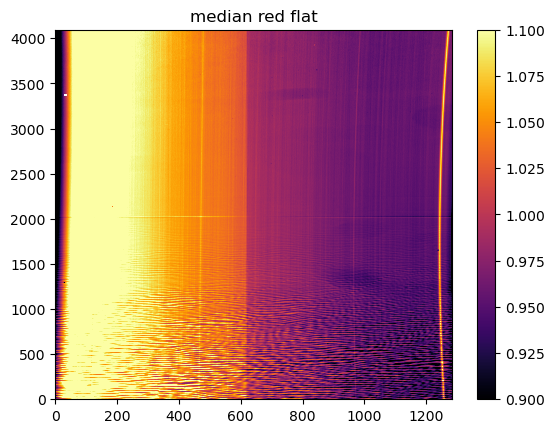

In [18]:
# Wrapper around Combiner, the spectral response normalization, and the illumination correction.
# This should work WITH or WITHOUT bias.
# Combining the red flat files using the "flatcombine" function defined above and plotting the combined red flat frame.
redflat_darknotsub, redilum_darknotsub = pipe.flatcombine(redflatfiles, bias = bias, Saxis = 1, Waxis = 0)
plt.imshow(redflat_darknotsub, origin='lower', aspect='auto', cmap=plt.cm.inferno)

##############SAVING THE SCIENCE IMAGE###############
# Choosing file name.
filename = 'median red flat.fits'
hdu = fits.PrimaryHDU(redflat_darknotsub)
hdu.writeto(path_personal / filename,overwrite = True)
#####################################################

plt.clim(.9,1.1)
plt.title('median red flat')
cb = plt.colorbar()

# Gaia 0864.0001 processed with "apo_proc"

Reducing science image Gaia 0864.0001 with "apo_proc" function defined above (not subtracting darks) and plotting the resulting image. Again, the user should subtract darks if needed (just by adding the "dark" parameter) and, in this case, use flats from which darks were subtracted.

In [65]:
%matplotlib qt
# Opening the science image as a "fits" file object.
sci = directory_orig +  'HD29883_RV.0060.fits'#'Gaia0864.0001.fits'
# Appending "DATASEC" keyword to the header of the science image.
# This step is unnecessary if you have one data section of CCD,
# therefore, please check your header, since you may alredy have "DATASEC" in it.
# The "DATASEC" combines into one "CSEC11" and "CSEC12" - the two data sections of CCD.
# If using, please run the following block of code (until the next comment) only once,
# otherwise the keyword will be appended to the header every time you run it.
# To avoid running this code multiple times, after running it once, just comment it out.
hdul = fits.open(sci, 'update')
hdr = hdul[0].header
if 'DATASEC' not in hdr:
    hdr["DATASEC"] = "[1:2048,1:4096]"
    hdr.comments["DATASEC"] = "data section of CCD (unbinned)"
    hdul.flush()
hdul.close()

# Using "apo_proc" function defined above to reduce the science image.
sciimg = pipe.apo_proc(sci, bias = bias, ilum = redilum_darknotsub, flat = redflat_darknotsub, Saxis = 1, Waxis =0, CR = False)
# Plotting the resulting science image.
plt.imshow(sciimg, origin='lower', aspect='auto')
plt.clim((0, 1))
#cb = plt.colorbar()
plt.title(sci)




the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


INFO: overwriting masked ndarray's current mask with specified mask. [astropy.nddata.nddata]


Text(0.5, 1.0, 'UT230908/UT230908/UT230908/HD29883_RV.0060.fits')

# Identifying hot pixels

Calculating dark current for each trimmed dark frame.

In [20]:
# This block of code trims each dark frame, writes the trimmed
# dark frames into text file "darkfiles_trimmed.txt", and saves them in the directory
# provided by the user in the "darkcombine" function.
with open('darkfiles_trimmed.txt', 'w') as f:
      count = 1
      for darkfile in darkfiles_def:
        hdul = fits.open(darkfile, 'update')
        hdr = hdul[0].header
        if 'DATASEC' not in hdr:
            
        # Please make sure to run the following block of code (until the next comment) only once,
        # otherwise, you will be appending "DATASEC" keyword each run, making unsuccessful attempts to remove cards
        # from the header that have already been removed, and saving files that already exist.
        # Thus, please comment this block of code out once you run it.
        # The keywords removed from the header in this code are specific to the particular data used in this pipeline.
        # If you have cards that are not in the "fits" format, just replace the keywords in this pipeline with yours.
        # Otherwise, the following two lines will not be needed.
        #for key in ["CD1_1", "CD1_2", "CD2_1", "CD2_2"]:
         #  hdr.remove(key)
            hdr["DATASEC"] = "[1:2048,1:4096]"
            hdr.comments["DATASEC"] = "data section of CCD (unbinned)"
            hdul.flush()
            #hdul.writeto(darkfile, overwrite = True)
            trimmed_darkfile = pipe.apo_proc(darkfile, ilum = redilum_darknotsub, Saxis = 1, Waxis =0)
            f.write("trimmed_darkfile{}.fits".format(count) + "\n")
            filename = "trimmed_darkfile{}.fits".format(count)
            hdu = fits.PrimaryHDU(trimmed_darkfile)
            hdu.writeto(path/filename, overwrite = True)
            hdu.writeto(path_personal / filename,overwrite = True) #This is my personal copy for analizing images and troubleshoot the code
            count += 1
        else:
            trimmed_darkfile = pipe.apo_proc(darkfile, ilum = redilum_darknotsub, Saxis = 1, Waxis =0)
            f.write("trimmed_darkfile{}.fits".format(count) + "\n")
            filename = "trimmed_darkfile{}.fits".format(count)
            hdu = fits.PrimaryHDU(trimmed_darkfile)
            hdu.writeto(path/filename, overwrite = True)
            hdu.writeto(path_personal / filename,overwrite = True) #This is my personal copy for analizing images and troubleshoot the code
            count += 1
# Read the text file into a table, the list of column names to use has only one name, "impath".
# Returning an array of the trimmed dark frames.
trimmed_darkfiles_i = pd.read_table("darkfiles_trimmed.txt", names = ['impath'])
trimmed_darkfiles = directory_new + trimmed_darkfiles_i['impath'].values
# Create a list of each frame's dark current by looping through the trimmed dark images,
# calculating the dark current, and appending it to the list.
dark_current_list = []
count = 1
for trimmed_darkfile in trimmed_darkfiles:
  hdul = fits.open(trimmed_darkfile)
  dark_current = hdul[0].data * (gain * u.electron / u.adu) / (exposure * u.second)
  dark_current_list.append(dark_current)
  count += 1

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Enabling interaction with the widget.

In [15]:
# Use this code to enable interaction with the widget:
'''
sudo apt install python3-ipympl (github repository download required  // it needs to be imported as ipympl-main)
sudo apt install python3-ipywidgets
sudo apt install python3-matplotlib
sudo apt install python3-mpl-interactions  (github repository download required  // it needs to be imported as ipympl-main)
'''
#%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
#from google.colab import output
output.enable_custom_widget_manager()
# If you ever want to disable it (which will help with later steps), use the following:
# output.disable_custom_widget_manager()

IntSlider(value=5, description='Slider:', max=10)

In [16]:
# Create some widgets
text = widgets.Text(
    value='Hello World',
    placeholder='Type something',
    description='Text:',
    disabled=False
)

slider = widgets.IntSlider(
    value=5,
    min=0,
    max=10,
    step=1,
    description='Slider:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

checkbox = widgets.Checkbox(
    value=False,
    description='Check me',
    disabled=False,
    indent=True
)

button = widgets.Button(
    description='Click Me',
    disabled=False,
    button_style='',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'  # (FontAwesome names without the `fa-` prefix)
)


# Create a layout
widget_box = widgets.VBox([text, slider, checkbox, button])

# Display the layout
display(widget_box)


Plotting a histogram of dark currents.

In [22]:
# Plot a histogram of dark currents.
plt.figure(figsize = (20,10))
num = 1
colors = ['red', 'blue', 'gray']
for dark_cur in dark_current_list:
  plt.hist(dark_cur.flatten(), bins = 100, density = False, color = colors[num - 1], alpha = 0.3)
  num += 1
plt.xlabel('Dark current, $e^-$/sec')
plt.ylabel('Number of pixels')
plt.loglog()

[]

Plotting hot pixels from one dark frame against another. Ideally, the user should have 2 combined dark frames with 2 different exposure times. According to the histogram, the user should set the boundary for hot pixels where the dark frame with the lowest dark current exceeds the value where the "tail" of the histogram "diverges". In the data used in this pipeline, only 1 combined dark frame exists because three darks with the same exposure time were taken during 1 night. Therefore, the accurate analysis of hot pixels cannot be conducted with this data, but it will be used to show the user how to conduct this analysis correctly.

In [23]:
%matplotlib inline

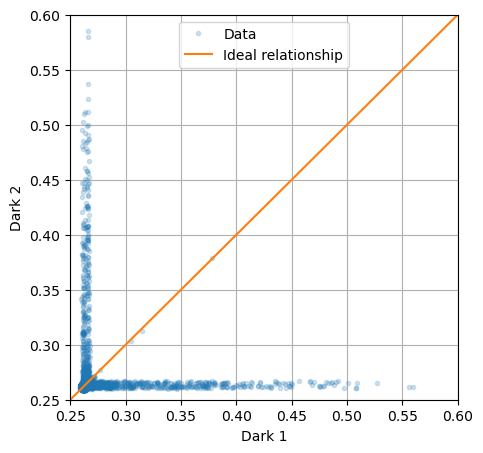

In [24]:
# Defining preliminary hot pixels.
hot_pixels = (dark_current_list[1] > 0.001 * u.electron /(u.adu * u.s))
plt.figure(figsize = (5, 5))
# The user should plot preliminary hot pixels from each of the 2 combined dark frames
# he/she is using against each other.
# If there are no hot pixels in the data, the "bubbles" will have "Ideal relationship" (1-1)
# and follow the "Ideal relationship" line. At the point where the "bubbles" start to diverge, hot pixels begin.
# Since in this pipeline 3 single dark frames with the same exposure time are used to provide
# code template that the user can utilize, 3 plots will be made (instead of 1 that the user will need).
# The behavior of the "bubbles" will also not follow the description above, and so
# the user should not be concerned about that.
# Here, comparing the data from first and second dark images in the list.
plt.plot(dark_current_list[0][hot_pixels].flatten(), dark_current_list[1][hot_pixels].flatten(), '.', alpha = 0.2,
         label = 'Data')
plt.xlabel("Dark 1")
plt.ylabel("Dark 2")
plt.plot([0, 100], [0, 100], label = 'Ideal relationship')
plt.grid()
plt.xlim(0.25, 0.6)
plt.ylim(0.25, 0.6)
plt.legend()

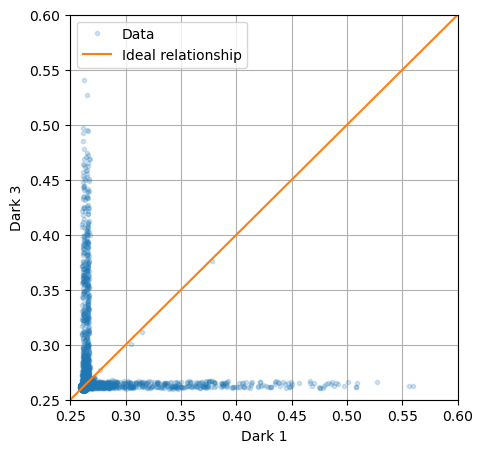

In [25]:
# Here, comparing the data from first and third dark images in the list.
plt.figure(figsize = (5,5))
plt.plot(dark_current_list[0][hot_pixels].flatten(), dark_current_list[2][hot_pixels].flatten(), '.', alpha = 0.2,
         label = 'Data')
plt.xlabel("Dark 1")
plt.ylabel("Dark 3")
plt.plot([0, 100], [0, 100], label = 'Ideal relationship')
plt.xlim(0.25, 0.6)
plt.ylim(0.25, 0.6)
plt.grid()
plt.legend()

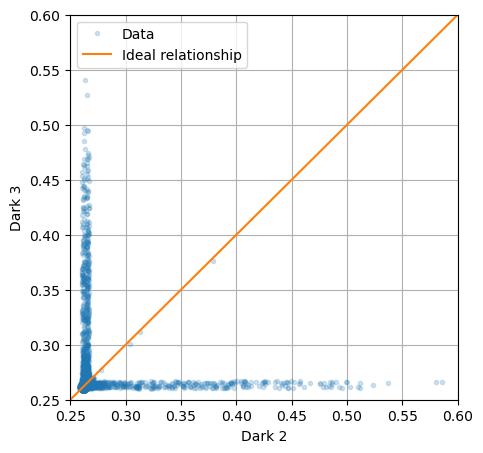

In [26]:
# Here, comparing the data from the second and third dark images in the list.
plt.figure(figsize = (5,5))
plt.plot(dark_current_list[1][hot_pixels].flatten(), dark_current_list[2][hot_pixels].flatten(), '.', alpha = 0.2,
         label = 'Data')
plt.xlabel("Dark 2")
plt.ylabel("Dark 3")
plt.plot([0, 100], [0, 100], label = 'Ideal relationship')
plt.xlim(0.25, 0.6)
plt.ylim(0.25, 0.6)
plt.grid()
plt.legend()

In [27]:
# At this point, it is best to turn off interactivity.
#%matplotlib inline

Final choice of hot pixels.

In [28]:
# According to the plot of hot pixels, the user should set the boundary for hot pixels
# where the dark frame with the highest dark current exceeds the value
# where the "bubbles" "diverge". In the data used in this pipeline, the "bubbles" diverge right away,
# which is expected because three darks with the same exposure time taken during 1 night
# are used intead of 2 combined dark frames with 2 different exposure times.
# Therefore, the user should not pay attention to these results.
bad_hot_pixels = (dark_current_list[2] > 0.26 * u.electron /(u.adu * u.s))
bad_hot_pixels.sum()

5240047

Converting the array of hot pixels into array of boolean values. Inverting the resulting mask so that True (or 1) values become False (or 0) so that when applying the mask the hot pixels are multiplied by 0 and hence get masked.

In [29]:
bad_hot_pixel_mask = bad_hot_pixels.astype('bool')
inv_bad_hot_pixel_mask = (bad_hot_pixel_mask - 1) * (-1)

In [30]:
print(inv_bad_hot_pixel_mask)

[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Bad pixel mask

Creating an array of calibrated (bias-subtracted) red flats to work with.

In [31]:
# This block of code subtracts bias from each flat file, writes the calibrated
# flat frames into text file "redflatlist_cal.txt", and saves them in the directory
# provided by the user in the "darkcombine" function. The user should use path to the combined bias frame
# when subtracting bias.
# Please make sure to run the following block of code (until the next comment) only once,
# otherwise, you will be attempting to save files that already exist.
# Thus, please comment this block of code out once you run it.
with open('redflatlist_cal.txt', 'w') as f:
      count = 1
      for redflatfile in redflatfiles:
        calibrated_redflatfile = fits.getdata(redflatfile)
        - fits.getdata("reduced file/bias_combined.fits")
        f.write("calibrated_redflatfile{}.fits".format(count) + "\n")
        filename = "calibrated_redflatfile{}.fits".format(count)
        hdu = fits.PrimaryHDU(calibrated_redflatfile)
        #hdu.writeto(path/filename, overwrite = True)
        count += 1
# Read the text file into a table, the list of column names to use has only one name, "impath".
# Returning an array of the calibrated flat frames.
redflatfilescal_i = pd.read_table("redflatlist_cal.txt", names = ['impath'])
redflatfilescal = directory_new + redflatfilescal_i['impath'].values
redflatfilescal

array(['reduced file/ignas/calibrated_redflatfile1.fits'], dtype=object)

Finding mean counts in each calibrated flat frame.

In [32]:
# This block of code calculates and prints out mean counts in each calibrated flat file.
for redflat in redflatfilescal:
  hdul = fits.open(redflat)
  mean_counts = np.mean(hdul[0].data)
  print(mean_counts)

69599.56608129747


If the mean counts are very similar in each flat frame, the mask needs to be build using any one of the frames. If they are very different, a ratio of the flats with the highest and lowest masks should be used. In this pipeline, the mask is created using one of the flats, because the mean counts are very similar in each flat frame.

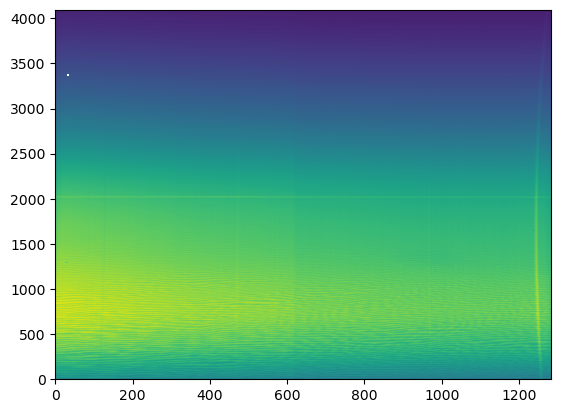

In [33]:
# The block below appends "EXPTIME" keyword to the header of the file containing
# a single calibrated flat frame (the user can pick any of the flat frames being used).
# Appending "EXPTIME", which has the same value as that of the raw flat frame provided by the user.
# Appending "DATASEC" keyword.
# The "DATASEC" combines into one "CSEC11" and "CSEC12" - the two data sections of CCD.
# Please run the following block of code (until the next comment) only once,
# otherwise the keywords will be appended to the header every time you run it.
# To avoid running this code multiple times, after running it once, just comment it out.
# This is the end of the following line that is not visible in GitHub: .fits")
flat_orig = fits.open('UT230908/UT230908/UT230908/Flat_RV-2.0053.fits')#int_red_flat_1.18cent.0002.fits")
header = flat_orig[0].header
exptime = header['EXPTIME']
flat_tobetrimmed = "reduced file/calibrated_redflatfile1.fits"
hdul = fits.open(redflatfilescal[0], 'update')
hdr = hdul[0].header
if 'DATASEC' not in hdr:
    hdr["DATASEC"] = "[1:2048,1:4096]"
    hdr.comments["DATASEC"] = "data section of CCD (unbinned)"
    hdr["EXPTIME"] = exptime
    hdul.flush()
hdul.close()

#hdul.writeto(flat_tobetrimmed, overwrite = True)
# Trimming the bias and not illuminated sections of the calibrated flat frame so that
# it has the same size as the reduced science image.
trimmed_flat = pipe.apo_proc(flat_tobetrimmed, ilum=redilum_darknotsub, Saxis = 1, Waxis =0)
#plt.show()
plt.imshow(trimmed_flat, origin='lower', aspect='auto')


#############SAVING THE SCIENCE IMAGE################
# Choosing file name.
filename = 'Trimmed Flat.fits'
hdu = fits.PrimaryHDU(trimmed_flat)
hdu.writeto(path_personal / filename,overwrite = True)
####################################################

Creating the mask.

In [34]:
# Printing the wall time for the entire cell (CPU times and Wall time).
#%%time
import ccdproc as ccdp
# Creating the mask.
mask = ccdp.ccdmask(trimmed_flat)

In [35]:
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Inverting the mask so that False (or 0) values become True (or 1) so that when applying the mask the bad pixels are multiplied by 0 and hence get masked. (The mask encodes good pixels with False (or 0) and bad with True (or 1)).

In [36]:
inv_mask = (mask - 1) * (-1)

In [37]:
inv_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

# Masking the science image

Applying the mask(s) to the science image and eliminating cosmic rays. The user should apply either hot pixel mask, or bad pixel mask, or both based on his/her data. The mask that has larger size should be applied first.

Starting 5 L.A.Cosmic iterations
Iteration 1:
1029 cosmic pixels this iteration
Iteration 2:
616 cosmic pixels this iteration
Iteration 3:
707 cosmic pixels this iteration
Iteration 4:
720 cosmic pixels this iteration
Iteration 5:
764 cosmic pixels this iteration


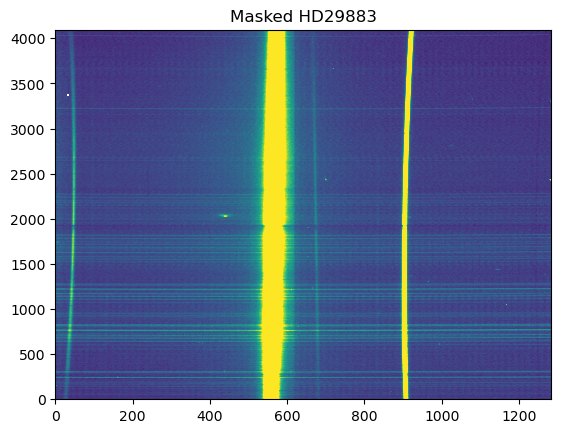

"\n##############SAVING THE SCIENCE IMAGE###############\n# Choosing file name.\nfilename = 'Masked HD29883.fits'\nhdu = fits.PrimaryHDU(final_sciimg)\nhdu.writeto(path_personal / filename,overwrite = True)\n#####################################################\n"

In [38]:
#%matplotlib qt
# Due to a characteristic of widget that was being disabled earlier,
# please make sure to run this block of code twice. Otherwise
# all pictures that were plotted when widget was enabled would be shown
# (instead of just one intended in this block of code).
# Combining and applying the masks to the science image.
# If the user only needs to use one of the masks, he/she should simply multiply the mask by the science image.
# Ex. 1 (applying the hot pixel mask only): sciimg_masked = sciimg * inv_bad_hot_pixel_mask
# Ex. 2 (applying the bad pixel mask only): sciimg_masked = sciimg * inv_mask
combined_mask = inv_mask | inv_bad_hot_pixel_mask
sciimg_masked = sciimg * combined_mask
# Multiplying the masked science image data by gain.
sciimg_masked_gaincorr = sciimg_masked.data * gain * u.electron/u.second
# Creating cosmic ray mask. Please be sure to find your own telescope's saturation level.
# "sigclip" is the parameter with the most direct effect on how many cosmic rays are found and masked.
# If the user feels as though this version hasn't found enough cosmic rays (there are still visible defects),
# he/she needs to lower the value of "sigclip".
# If the user feels that the mask caught things that are not cosmic rays, then
# he/she should increase the value of "sigclip" to mask fewer pixels.
cosmic_mask = ccdp.cosmicray_lacosmic(sciimg_masked_gaincorr, sigclip = 0.407951342, readnoise = read_noise, gain = gain,
                                      satlevel = 262000, niter = 5, verbose = True)
# Inverting the mask so that False (or 0) values become True (or 1) so that when applying the mask pixels
# affected by cosmic rays are multiplied by 0 and hence get masked.
# (The mask encodes good pixels with False (or 0) and affected with True (or 1)).
inv_cosmic_mask = ~cosmic_mask[1]
# Applying the cosmic ray mask to the masked science image.
final_sciimg = sciimg_masked * inv_cosmic_mask
# Plotting the resulting masked science image.
plt.imshow(final_sciimg, origin='lower', aspect='auto')
#cb = plt.colorbar()
plt.clim(0,1)
plt.title("Masked HD29883")
plt.show()
'''
##############SAVING THE SCIENCE IMAGE###############
# Choosing file name.
filename = 'Masked HD29883.fits'
hdu = fits.PrimaryHDU(final_sciimg)
hdu.writeto(path_personal / filename,overwrite = True)
#####################################################
'''

Text(0.5, 1.0, 'UT230908/UT230908/UT230908/HD29883_RV.0060.fits')

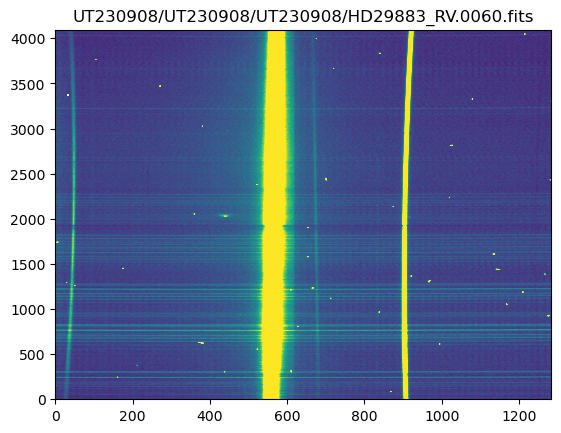

In [39]:
plt.figure()
plt.imshow(sciimg, origin='lower', aspect='auto')
plt.clim((0, 1))
#cb = plt.colorbar()
plt.title(sci)

In [40]:
print(final_sciimg.shape)

(4096, 1284)


In [41]:
print(1330/2)

665.0


# Trace for Gaia0864.0001

Tracing spectrum aperture in the science image and displaying the result.

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


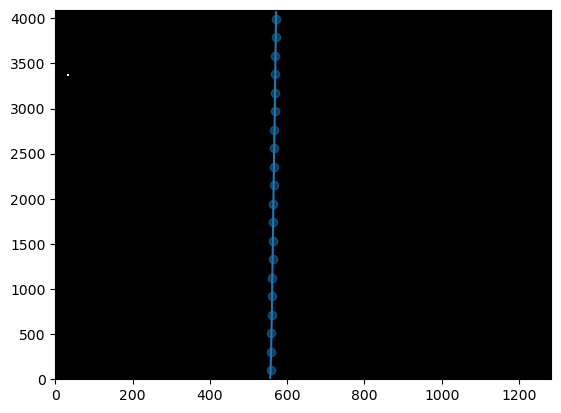

In [42]:
# Tracing star spectrum using Jim Davenport's "kosmos.trace" function.
# Use zoom provided by widget to ensure tracing accuracy and change "guess",
# "window", and "nbins" as needed to achieve quality fit.
#%matplotlib widget
sci_trace = pykosmos.trace(final_sciimg, display = True, guess = 566, window = 10, Saxis = 1, Waxis = 0, nbins = 20)

# BoxcarExtract for Gaia 0864.0001

Extracting spectrum using trace from the science image from above and displaying the result.

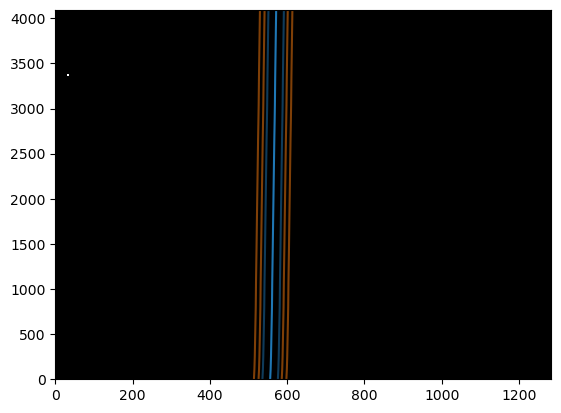

In [43]:
# Converting the masked science image into CCDData object
# (because the following function takes CCDData object as a parameter).
# Use zoom provided by widget to ensure accurate spectrum extraction.
# Change "apwidth", "skysep", and "skywidth" as needed.
ccd_final_sciimg = CCDData(final_sciimg, wcs = sciimg.wcs, unit = sciimg.unit)
# Using Jim Davenport's "kosmos.BoxcarExtract" function to extract spectrum from one star.
sci_ex, sci_sky = pykosmos.BoxcarExtract(ccd_final_sciimg, sci_trace, display = DISPLAY, apwidth = 20,
                                       skysep = 10, skywidth = 12, Saxis = 1, Waxis = 0)

Plotting counts vs. pixels in a science image.

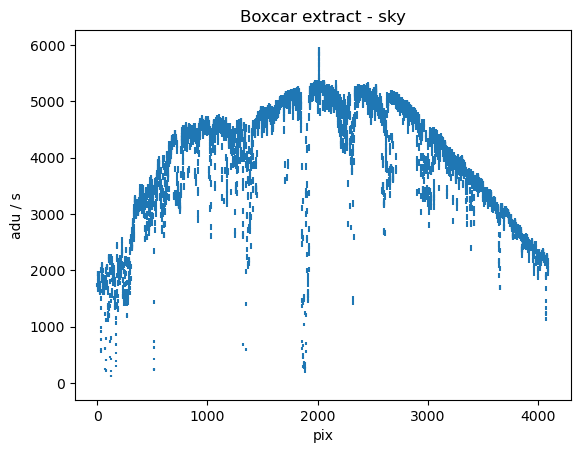

In [44]:
# Plotting a graph of counts vs. pixels in the science image.
# Due to a characteristic of widget that is being disabled in this cell,
# please make sure to run this block of code twice. Otherwise
# all pictures that were plotted when widget was enabled would be shown
# (instead of just one intended in this block of code).
#%matplotlib inline
if DISPLAY:
    plt.figure()
    plt.errorbar(sci_ex.spectral_axis.value, sci_ex.flux.value - sci_sky.flux.value,
                 yerr = sci_ex.uncertainty.array, linestyle = 'none')
    plt.xlabel(sci_ex.spectral_axis.unit)
    plt.ylabel(sci_ex.flux.unit)
    plt.title('Boxcar extract - sky')
    plt.show()

# NeLamp.0003 processed with "apo_proc"

Opening an ARC LAMP. Appending "DATASEC" keyword to its header. Applying some basic processing to it and displaying it.

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


INFO: overwriting masked ndarray's current mask with specified mask. [astropy.nddata.nddata]


/usr/lib/python3/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


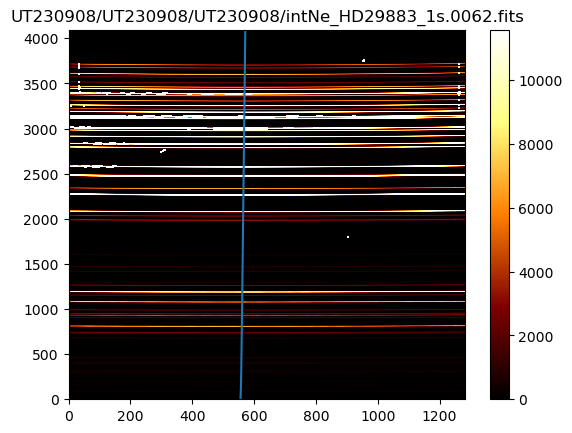

In [45]:
# Opening an arc lamp. Use the one that corresponds to science image in terms of
# grism color, slit position, and exposure time.
arcfile = directory_orig + 'intNe_HD29883_1s.0062.fits'
# Appending "DATASEC" keyword to the header of the arc lamp file.
# This step is unnecessary if you have one data section of CCD,
# therefore, please check your header, since you may alredy have "DATASEC" in it.
# The "DATASEC" combines into one "CSEC11" and "CSEC12" - the two data sections of CCD.
# If using, please run the following block of code (until the next comment) only once,
# otherwise the keyword will be appended to the header every time you run it.
# To avoid running this code multiple times, after runnTheing it once, just comment it out.
hdul = fits.open(arcfile, 'update')
hdr = hdul[0].header
if 'DATASEC' not in hdr:
    #hdr.append("DATASEC")
    hdr["DATASEC"] = "[1:2048,1:4096]"
    hdr.comments["DATASEC"] = "data section of CCD (unbinned)"
    hdul.flush()
hdul.close()
#hdul.writeto(arcfile, overwrite = True)
# Using "apo_proc" function defined above to reduce the arc lamp image.
arcimg = pipe.apo_proc(arcfile, bias = bias, ilum = redilum_darknotsub, Saxis = 1, Waxis = 0)
# Plotting the resulting arc lamp image.
if DISPLAY:
    plt.figure()
    plt.imshow(arcimg, origin ='lower', aspect ='auto', cmap = plt.cm.afmhot)
    plt.plot(sci_trace, np.arange(len(sci_trace))) # for illustration, overplot the trace
    plt.clim(np.percentile(arcimg, (5, 97)))
    cb = plt.colorbar()
    plt.title(arcfile)
    
##############SAVING THE SCIENCE IMAGE###############
# Choosing file name.
filename = 'Arc Lamp Image.fits'
hdu = fits.PrimaryHDU(arcimg)
hdu.writeto(path_personal / filename,overwrite = True)
#####################################################

# Plot of Neon Wavelengths

For the data used in this pipeline, wavelengths for neon lamp with red grism, center slit, and 2 sec exposure time are used. The user needs to reference a plot with labeled wavelengths that will match the data under consideration. This plot can be found in the instrument documentation.

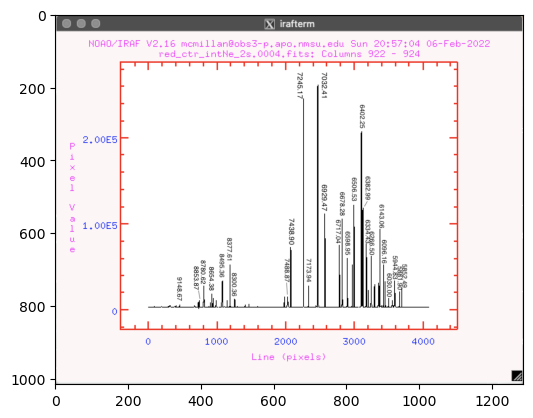

In [46]:
# Once you have the image file from calibration lamp, you need to be able to look at the reference plot
# with labeled wavelengths from APO KOSMOS documentation.
# The plot is included here, but it might be easier to just have it open in another tab or document.
plt.figure()
img = plt.imread("08ix6q46.png")
Neref = plt.imshow(img)
plt.show()

# BoxcarExtract for NeLamp.0003, trace from Gaia 0864.0001

Extracting spectra across arc lamp image. Plotting the resulting graph.

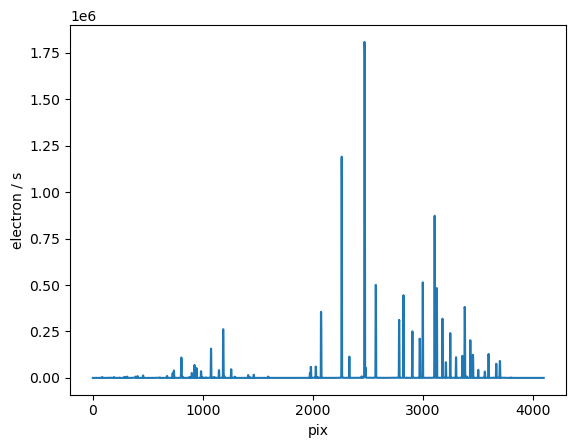

In [47]:
# Using Jim Davenport's "kosmos.BoxcarExtract" function to extract spectra across the arc lamp image.
sciarc_ex, _ = pykosmos.BoxcarExtract(arcimg, sci_trace, apwidth = 3, skysep = 5, skywidth = 5, Saxis = 1, Waxis = 0)
# Plotting a graph of counts vs. pixels in the arc lamp image.
if DISPLAY:
    plt.figure()
    plt.plot(sciarc_ex.spectral_axis.value, sciarc_ex.flux.value)
    plt.xlabel(sciarc_ex.spectral_axis.unit)
    plt.ylabel(sciarc_ex.flux.unit)

# Wavelength calibration for Gaia 0864.0001

Identifying wavelengths with "identify.widget" using arc lamp lines.

In [48]:
# Now we use the kosmos function, "kosmos.identify_widget".
# The instructions will pop up with the widget telling you how to use it.
# For this process specifically, you need to look at the wavelengths on the
# reference picture from APO and find wavelengths that match.
# Then you click on the line in the picture that matches and type in what wavelength it is supposed to be.
# Try to match 5 or 6, from different parts of the image.
%matplotlib widget
sci_xpts_ne, sci_wpts_ne = pykosmos.identify_widget(sciarc_ex)


    Instructions:
    ------------
    0) For proper interactive widgets, ensure you're using the Notebook backend
    in the Jupyter notebook, e.g.:
        %matplotlib notebook
    1) Click on arc-line features (peaks) in the plot. The Pixel Value box should update.
    2) Enter the known wavelength of the feature in the Wavelength box.
    3) Click the Assign button, a red line will be drawn marking the feature.
    4) When you've identified all your lines, stop the interaction for (or close) the figure.


Copying & pasting the "sci_xpts_ne" and "sci_wpts_ne" that the cell above outputs. Need to use the last line of the output only. The first list has "sci_xpts_ne" - x-points, the second list has "sci_wpts_ne" - wavelengths. This is done to avoid working on the cell above more than once, which saves time.

In [49]:
sci_xpts, sci_wpts = pykosmos.wave_cal(base_file= 'apox_neon_xpoints.dat',neon_spectra=sciarc_ex,standardize_wave_file='copy_new_neon_red_center.dat',
                                      poly =3, autotol_value = 25, npixels=1)

[2458.03695608036, 2250.9881556333617, 2327.105919342044, 2069.625852627165, 2560.689077068269, 1173.2500309643165, 1071.3454641980682, 802.6364314645228, 2818.2850856348705, 2986.878910663603, 3101.7903694516717, 3368.0498801832355, 3425.3146771762144]
 waves 
-------
7032.41
7245.17
7173.94
 7438.9
6929.47
    ...
6678.28
6506.53
6402.25
6143.06
6096.16
Length = 13 rows
[8780.62 8495.36 8377.61 7438.9  7245.17 7173.94 7032.41 6929.47 6678.28
 6506.53 6402.25 6143.06 6096.16]
24 lines matched from 30 within estimated range.


In [50]:
# Checking how well it lines up:
plt.figure(figsize = (10, 4))
plt.plot(sciarc_ex.spectral_axis, sciarc_ex.flux)
plt.title(label = "Calibration Lamp Spectrum", fontfamily = 'sans-serif', fontsize = 10.0)
plt.xlabel(sciarc_ex.spectral_axis.unit, fontsize = 7)
plt.ylabel(sciarc_ex.flux.unit, fontsize = 7)
plt.xticks(fontfamily = 'sans-serif',fontsize = 7)
plt.yticks(fontfamily = 'sans-serif',fontsize = 7)
for val in sci_xpts:
  plt.axvline(x = val, ls = '--')
# Updating "xpts_values":

In [51]:
sci_xpts_ne = [2458.0369639439778, 2250.988169002858, 3092.0919354838707, 1173.2501007880307,
               3368.0522164085364, 2069.625852627164]

In [52]:
sci_wpts_ne = [7032.41, 7245.17, 6402.25, 8377.61, 6143.06, 7438.9]

Checking whether guessed x-points are right on the peak of the wavelengths.

In [53]:
# Now that we have the list of guessed x-points and their related wavelength values,
# we can use the following method to make sure our guessed x-points are actually right on the peak of the wavelength.
npixels = 15   # This is the area around your guess that the new approximation will search for a peak within.
axis = sciarc_ex.spectral_axis
ne_spectrum = sciarc_ex.flux
# In order for the indexing to work in the next step,
# we need to make a list of the nearest integer to our guessed "xpts".
integer_xpts = []
for x in sci_xpts_ne:
  integer_xpts.append(int(x - x % 1))
improved_xpts = [np.average(axis[g - npixels:g + npixels],weights = ne_spectrum[g - npixels:g + npixels]
                            - np.median(ne_spectrum)) for g in integer_xpts]
# Print improved and original "xvals" to compare:
print(improved_xpts)
print(sci_xpts_ne)
# Checking how well it lines up:
plt.figure(figsize = (10, 4))
plt.plot(sciarc_ex.spectral_axis, sciarc_ex.flux)
for val in improved_xpts:
  plt.axvline(x = val.value, ls = '--')

[<Quantity 2468.09313354 pix>, <Quantity 2260.2134449 pix>, <Quantity 3103.88710992 pix>, <Quantity 1184.06345311 pix>, <Quantity 3372.55564788 pix>, <Quantity 2073.11613947 pix>]
[2458.0369639439778, 2250.988169002858, 3092.0919354838707, 1173.2501007880307, 3368.0522164085364, 2069.625852627164]


Preparing wavelength data for Jim Davenport's "kosmos.identify_nearest" function that will identify more wavelengths using arc lamp lines.

In [54]:
# Now that we have "xpts" and "wpts", get them into the right format.
sci_wpts_ne = sci_wpts_ne *  u.angstrom   # Make sure you only run this line once.
xpts_values = []
for val in improved_xpts:
  xpts_values.append(val.value)
print(xpts_values)
print(sci_wpts_ne)
# Sort, just in case.
srt = np.argsort(xpts_values)
xpt = np.array(xpts_values)[srt]
wpt = np.array(sci_wpts_ne)[srt]
print(wpt)
fit = np.polyfit(xpt, wpt, deg = 3)
wavesolved = np.polyval(fit, sciarc_ex.spectral_axis.value)
print(wavesolved)

[2468.093133538546, 2260.2134448995316, 3103.887109915284, 1184.0634531067944, 3372.5556478772387, 2073.116139468527]
[7032.41 7245.17 6402.25 8377.61 6143.06 7438.9 ] Angstrom
[8377.61 7438.9  7245.17 7032.41 6402.25 6143.06]
[9664.83412618 9663.73889895 9662.64367656 ... 5481.42134273 5480.53571286
 5479.65018059]


Preparing a table of strong emission lines. For the data used in this pipeline, wavelengths for neon lamp with red grism, center slit, and 2 sec exposure time are used. The user needs to reference a plot with labeled wavelengths that will match the data under consideration. This plot can be found in the instrument documentation.

In [55]:
# Use a table of strong emission lines with units.
# This table can be constructed using appropriate for the data under consideration reference plot
# with labeled wavelengths from APO KOSMOS documentation.
henear_tbl = Table.read('copy_new_neon_red_center.dat',
                        names = ('wave', 'name'), format = 'ascii')
henear_tbl['wave'].unit = u.angstrom
apo_henear = henear_tbl['wave']

Assigning as many wavelengths as possible.

In [56]:
# Using Jim Davenport's "kosmos.identify_nearest" function to match and assign
# more wavelengths referencing the plot of the wavelengths at rest.
# The "autotol" parameter can be adjusted as needed to ensure the best fit.
sci_xpts, sci_wpts = pykosmos.identify_nearest(sciarc_ex, wapprox = wavesolved * u.angstrom,
                                             linewave = apo_henear, autotol=3)

22 lines matched from 29 within estimated range.


Checking whether updated x-points are right on the peak of the wavelengths.

In [57]:
sci_xpts

array([2073.1073344 , 2260.2283525 , 2329.50934934, 2468.1457925 ,
       2569.69966617, 2781.91884068, 2821.05831835, 2901.56696761,
       2969.10299665, 2996.30812877, 3103.97750673, 3123.94880244,
       3174.7701855 , 3205.88346251, 3246.26530339, 3298.43785776,
       3355.72836359, 3377.75566572, 3428.28721988, 3451.92970741,
       3593.80863771, 3696.80711679])

In [58]:
# Now that we have our final list of guessed x-points and their related wavelength values,
# we can use the following method to make sure our guessed x-points are actually right on the peak of the wavelength.
integer_xpts_new = []
for x in sci_xpts:
  integer_xpts_new.append(int(x - x % 1))
improved_xpts_new = [np.average(axis[g - npixels:g + npixels], weights = ne_spectrum[g - npixels:g + npixels]
                                - np.median(ne_spectrum)) for g in integer_xpts_new]
# Checking how well it lines up:
plt.figure(figsize = (10, 4))
plt.plot(sciarc_ex.spectral_axis, sciarc_ex.flux)
plt.title(label = "Calibration Lamp Spectrum", fontfamily = 'sans-serif', fontsize = 10.0)
plt.xlabel(sciarc_ex.spectral_axis.unit, fontsize = 7)
plt.ylabel(sciarc_ex.flux.unit, fontsize = 7)
plt.xticks(fontfamily = 'sans-serif',fontsize = 7)
plt.yticks(fontfamily = 'sans-serif',fontsize = 7)
for val in improved_xpts_new:
  plt.axvline(x = val.value, ls = '--')
# Updating "xpts_values":
xpts_values_new = []
for val in improved_xpts_new:
  xpts_values_new.append(val.value)

Checking the quality of wavelength calibration. Please use zoom provided by widget to look closely at the prominent troughs and compare those wavelength values with those on the reference plots on this website: http://www.astrosurf.com/buil/us/vatlas/vatlas.htm.
If the difference is less than 1 Angstrom, the wavelength calibration should be reliable.

In [59]:
# Plotting the spectrum (sky is not subtracted).
sci_fit_check = pykosmos.fit_wavelength(sci_ex, xpts_values_new, sci_wpts, mode='poly', deg=3)
plt.figure(figsize = (10,4))
plt.plot(sci_fit_check.spectral_axis, sci_fit_check.flux)
plt.title("Calibrated Gaia0864.0001 Spectrum", fontsize = 10)
plt.xlabel( sci_fit_check.spectral_axis.unit, fontsize = 7)
plt.ylabel(sci_fit_check.flux.unit, fontsize = 7)
plt.subplots_adjust(bottom = 0.2)
plt.show()

qt.qpa.wayland: Wayland does not support QWindow::requestActivate()
qt.qpa.wayland: Wayland does not support QWindow::requestActivate()
qt.qpa.wayland: Wayland does not support QWindow::requestActivate()
qt.qpa.wayland: Wayland does not support QWindow::requestActivate()
qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


Subtracting sky from the actual spectrum, fitting the wavelength solution, plotting the resulting graph. Note that we could only use flux axis to perform subtraction: Python gives an error otherwise, because it doesn't want to deal with pixels, and the other axis is in pixels. This is the best and final fit. This spectrum can now be used for scientific analysis.

In [67]:
# Make the "sci_spectrum" using the material from "kosmos.trace" and "kosmos.BoxcarExtract" functions.
sci_spectrum = sci_ex.flux - sci_sky.flux
sci_spec = Spectrum1D(flux = sci_spectrum, spectral_axis = sci_ex.spectral_axis, uncertainty = sci_ex.uncertainty)
# And then input it into Jim Davenport's "kosmos.fit_wavelength" function.
sci_fit_final = pykosmos.fit_wavelength(sci_spec,xpts_values_new, sci_wpts, mode ='poly', deg = 3)
# Save the final spectrum. Please make sure to use "tabular-fits" format.
sci_fit_final.write('HD29883_RV.0060 Spectrum',
                    format = 'tabular-fits', overwrite=True)
plt.figure(figsize = (10,4))
plt.plot(sci_fit_final.spectral_axis, sci_fit_final.flux)
plt.title("HD29883_RV.0060 Spectrum", fontsize = 10)
plt.xlabel( sci_fit_final.spectral_axis.unit, fontsize = 7)
plt.ylabel(sci_fit_final.flux.unit, fontsize = 7)
plt.subplots_adjust(bottom = 0.2)
plt.show()

qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


In [61]:
print(dir(pykosmos))

['BoxcarExtract', '__author__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'air_to_vac', 'airmass_cor', 'apextract', 'apply_sensfunc', 'aprox_points', 'biascombine', 'find_illum', 'find_peaks', 'fit_wavelength', 'flat_response', 'flatcombine', 'flatfield', 'fluxcal', 'identify', 'identify_dtw', 'identify_nearest', 'identify_widget', 'imtools', 'loadarctemplate', 'loadlinelist', 'mag2flux', 'obs_extinction', 'onedstd', 'proc', 'script_reduce', 'standard_sensfunc', 'trace', 'wave_cal', 'wrappers']
